In [383]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.optimize import minimize
from itertools import product

In [384]:
np.random.seed(42)

There are 11 parameters governing the distribution $f$. Let's generate them randomly.

In [385]:
theta = np.random.uniform(0,1)

In [386]:
a = np.random.uniform(0,1)

In [387]:
b = 1 - a

In [388]:
c = np.random.uniform(0,1)

In [389]:
d = 1 - c

In [390]:
e = np.random.uniform(0,1)

In [391]:
f = np.random.uniform(0,1-e)

In [392]:
g = 1 - e - f

In [393]:
h = np.random.uniform(0,1)

In [394]:
j = np.random.uniform(0,1-h)

In [395]:
k = 1 - h - j

In [396]:
parameters = np.array([theta,a,b,c,d,e,f,g,h,j,k])

Consider the graph $\mathcal G$ given by $X\to Y\to Z$. By definition, $\mathbb P$ is Markov to $\mathcal G$ if its PDF $f(x,y,z)=f(z|y)f(y|x)f(x)$. Let's take the most general distributions for $X$, $Y|X$, and $Z|Y$. We'll use the 11 parameters that we generated above as coefficients.

We take $X\sim \mathrm{Bernoulli}(\theta)$, $Y|X=x$ to be given by
$$f_{Y|X}(x,y)=\delta_0(x)(a\delta_0(y)+b\delta_1(y)) + \delta_1(x)(c\delta_0(y)+d\delta_1(y))$$
and $Z|Y=y$ to be given by $$f_{Z|Y}(y,z)=\delta_0(y)\left(e\delta_0(z)+f\delta_1(z)+g\delta_2(z)\right)+\delta_1(y)(h\delta_0(z)+j\delta_1(z)+k\delta_2(z))$$ where $\delta_*$ denotes a Dirac delta function, each parameter is between 0 and 1, and $a+b=c+d=e+f+g=h+j+k=1$.

Then we have that $f(x,y,z)$ is the product 
$$\left(\delta_0(y)\left(e\delta_0(z)+f\delta_1(z)+g\delta_2(z)\right)+\delta_1(y)(h\delta_0(z)+j\delta_1(z)+k\delta_2(z))\right)\left(\delta_0(x)(a\delta_0(y)+b\delta_1(y)) + \delta_1(x)(c\delta_0(y)+d\delta_1(y))\right)(\theta \delta_1(x) + (1-\theta)\delta_0(x)).$$

In [397]:
print(f'Parameters: ({theta:.2f},{a:.2f},{b:.2f},{c:.2f},{d:.2f},{e:.2f},{f:.2f},{g:.2f},{h:.2f},{j:.2f},{k:.2f})')

Parameters: (0.37,0.95,0.05,0.73,0.27,0.60,0.06,0.34,0.16,0.05,0.79)


In [398]:
def generate_y_from_x(x, a=a, b=b, c=c, d=d):
    if x == 0:
        return np.random.choice([0,1], p=[a,b])
    else:
        return np.random.choice([0,1], p=[c,d])

In [399]:
def generate_z_from_y(y, e=e, f=f, g=g, h=h, j=j, k=k):
    if y == 0:
        return np.random.choice([0,1,2], p=[e,f,g])
    else:
        return np.random.choice([0,1,2], p=[h,j,k])

In [400]:
x = np.random.choice([0,1], p=[1-theta,theta], size=1000)

In [401]:
y = np.array(list(map(generate_y_from_x, x)))

In [402]:
z = np.array(list(map(generate_z_from_y, y)))

Text(0.5, 1.0, 'Histogram of $X$')

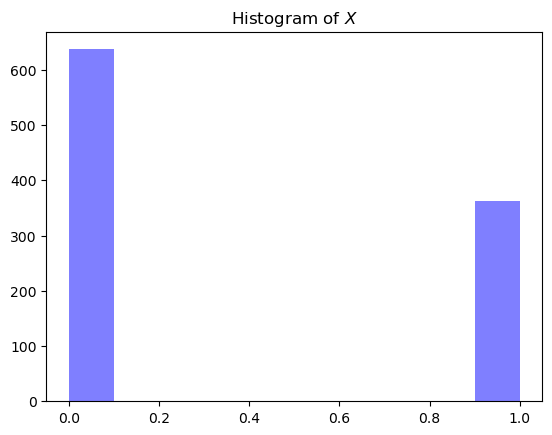

In [403]:
plt.hist(x, color='blue', alpha=0.5)
plt.title('Histogram of $X$')

Text(0.5, 1.0, 'Histogram of $Y$')

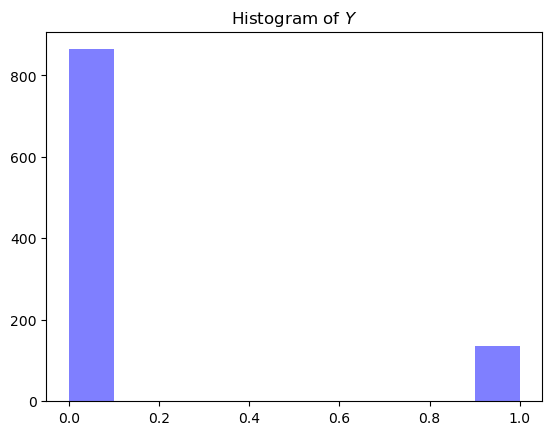

In [404]:
plt.hist(y, color='blue', alpha=0.5)
plt.title('Histogram of $Y$')

Text(0.5, 1.0, 'Histogram of $Z$')

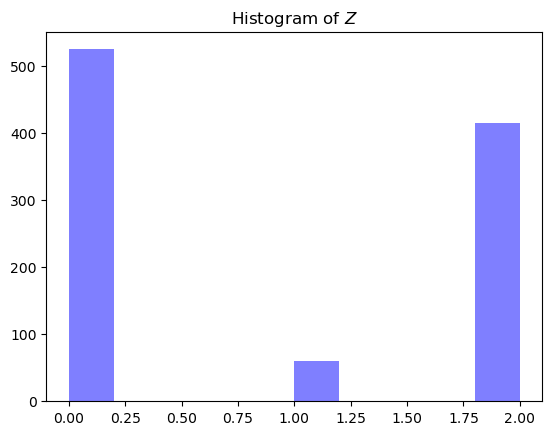

In [405]:
plt.hist(z, color='blue', alpha=0.5)
plt.title('Histogram of $Z$')

As a parametric model, we'll choose $X\sim \mathrm{Bernoulli}(\theta)$,
$$f_{Y|X}(x,y)=\delta_0(x)\left(a\delta_0(y)+b\delta_1(y)\right)+\delta_1(x)\left(c\delta_0(y)+d\delta_1(y)\right),$$ and
$$f_{Z|Y}(y,z)=\delta_0(y)\left(e\delta_0(z)+f\delta_1(z)+g\delta_2(z)\right) + \delta_1(y)\left(h\delta_0(z)+j\delta_1(z)+k\delta_2(z)\right).$$
Here $a+b=c+d=e+f+g=h+j+k=1$.

In [406]:
def pdf(x,theta):
    if x == 1:
        return theta
    else:
        return 1-theta

In [407]:
def pdf_y_cond_x(x,y,a,b,c,d):
    if x == 0:
        return a if y == 0 else b
    else:
        return c if y == 0 else d

In [408]:
def pdf_z_cond_y(y,z,e,f,g,h,j,k):
    if y == 0:
        if z == 0:
            return e
        elif z == 1:
            return f
        else:
            return g
    else:
        if z == 0:
            return h
        elif z == 1:
            return j
        else:
            return k

We'll use scipy's minimize method to compute the maximum likelihood estimates for the parameters of $f(x,y,z)$.

In [409]:
def log_likelihood(params,xs,ys,zs):
    theta,a,b,c,d,e,f,g,h,j,k=params
    loglikx = np.sum(np.log(np.array(list(map(lambda x: pdf(x,theta), xs)))))
    logliky = np.sum(np.log(np.array(list(map(lambda x: pdf_y_cond_x(x[1], x[0], a, b, c, d), zip(xs, ys))))))
    loglikz = np.sum(np.log(np.array(list(map(lambda x: pdf_z_cond_y(x[1], x[0], e, f, g, h, j, k), zip(ys, zs))))))
    
    return loglikx + logliky + loglikz

In [410]:
def f(params,xs,ys,zs):
    return -log_likelihood(params,xs,ys,zs)

In [411]:
data = (x,y,z)

Below we define an initial guess for the maximum likelihood parameters, bounds, and constraints for the optimization.

In [412]:
parameters

array([0.37454012, 0.95071431, 0.04928569, 0.73199394, 0.26800606,
       0.59865848, 0.06261676, 0.33872476, 0.15599452, 0.04902289,
       0.79498259])

In [413]:
initial_guess = [0.35,0.9,0.1,0.75,0.25,0.6,0.06,0.34,0.15,0.05,0.8]

In [414]:
def const1(t):
    return t[1]+t[2] - 1

In [415]:
def const2(t):
    return t[3]+t[4] - 1

In [416]:
def const3(t):
    return t[5]+t[6]+t[7] - 1

In [417]:
def const4(t):
    return t[8]+t[9]+t[10] - 1

In [418]:
bnds = [(0,1) for _ in range(11)]

In [419]:
constraints = [
    {
        'type':'eq', 'fun':const1
    },
    {
        'type':'eq', 'fun':const2
    },
    {
        'type':'eq', 'fun':const3
    },
    {
        'type':'eq', 'fun':const4
    },
]

In [420]:
result = minimize(f, args=data, x0=initial_guess, bounds=bnds, constraints=constraints)

/var/folders/h9/7qb3ygvs0mzb0cdjbh8z8svr0000gn/T/ipykernel_22710/3768204522.py:5: RuntimeWarning: divide by zero encountered in log
  loglikz = np.sum(np.log(np.array(list(map(lambda x: pdf_z_cond_y(x[1], x[0], e, f, g, h, j, k), zip(ys, zs))))))
/var/folders/h9/7qb3ygvs0mzb0cdjbh8z8svr0000gn/T/ipykernel_22710/3768204522.py:3: RuntimeWarning: divide by zero encountered in log
  loglikx = np.sum(np.log(np.array(list(map(lambda x: pdf(x,theta), xs)))))
/var/folders/h9/7qb3ygvs0mzb0cdjbh8z8svr0000gn/T/ipykernel_22710/3768204522.py:4: RuntimeWarning: divide by zero encountered in log
  logliky = np.sum(np.log(np.array(list(map(lambda x: pdf_y_cond_x(x[1], x[0], a, b, c, d), zip(xs, ys))))))


In [421]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1590.8326891538027
       x: [ 3.630e-01  6.979e-01  3.021e-01  2.500e-01  7.500e-01
            9.771e-01  2.286e-02  1.770e-09  7.389e-01  2.611e-01
            0.000e+00]
     nit: 23
     jac: [ 3.033e-02 -8.640e+02 -8.640e+02 -1.360e+02 -1.360e+02
           -5.250e+02 -5.250e+02  0.000e+00 -4.750e+02 -4.750e+02
            0.000e+00]
    nfev: 295
    njev: 23

In [422]:
out = result.x

Let's compare the true parameters to maximum likelihood parameters.

In [423]:
for i in range(len(out)):
    print('---')
    print(f'Actual parameter: {parameters[i]:.4f}')
    print(f'Estimated parameter: {out[i]:.4f}')
    print('---\n')

---
Actual parameter: 0.3745
Estimated parameter: 0.3630
---

---
Actual parameter: 0.9507
Estimated parameter: 0.6979
---

---
Actual parameter: 0.0493
Estimated parameter: 0.3021
---

---
Actual parameter: 0.7320
Estimated parameter: 0.2500
---

---
Actual parameter: 0.2680
Estimated parameter: 0.7500
---

---
Actual parameter: 0.5987
Estimated parameter: 0.9771
---

---
Actual parameter: 0.0626
Estimated parameter: 0.0229
---

---
Actual parameter: 0.3387
Estimated parameter: 0.0000
---

---
Actual parameter: 0.1560
Estimated parameter: 0.7389
---

---
Actual parameter: 0.0490
Estimated parameter: 0.2611
---

---
Actual parameter: 0.7950
Estimated parameter: 0.0000
---



The estimated parameters are not very close to the true parameters. Let's see if the histograms are similar using the estimated parameters.

In [424]:
x_pred = np.random.choice([0,1], p=[1-out[0], out[0]], size=1000)

Text(0.5, 1.0, 'Actual versus predicted distribution for x')

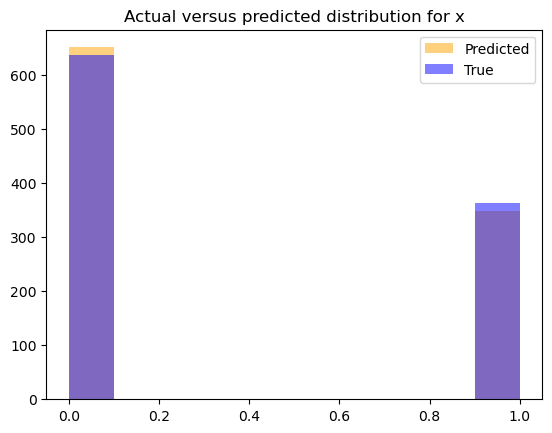

In [425]:
plt.hist(x_pred, color='orange', alpha=0.5, label='Predicted')
plt.hist(x, color='blue', alpha=0.5, label='True')
plt.legend()
plt.title('Actual versus predicted distribution for x')

In [426]:
y_pred = np.array(list(map(lambda x: generate_y_from_x(x,out[1],out[2],out[3],out[4]),
                           x_pred)))

Text(0.5, 1.0, 'Actual versus predicted distribution for y')

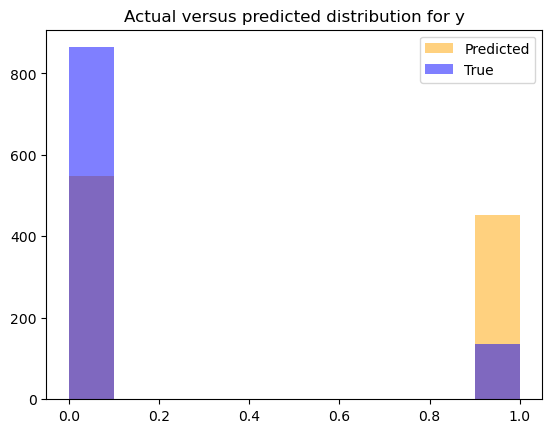

In [427]:
plt.hist(y_pred, color='orange', alpha=0.5, label='Predicted')
plt.hist(y, color='blue', alpha=0.5, label='True')
plt.legend()
plt.title('Actual versus predicted distribution for y')

In [428]:
z_pred = np.array(list(map(lambda y: generate_z_from_y(y, out[5],out[6],out[7],
                                                       out[8],out[9],out[10]), y_pred)))

Text(0.5, 1.0, 'Actual versus predicted distribution for z')

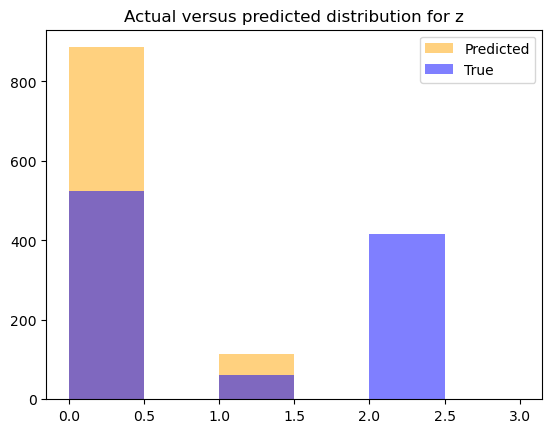

In [429]:
plt.hist(z_pred, color='orange', alpha=0.5, label='Predicted', bins=[0,0.5,1,1.5,2,2.5,3])
plt.hist(z, color='blue', alpha=0.5, label='True', bins=[0,0.5,1,1.5,2,2.5,3])
plt.legend()
plt.title('Actual versus predicted distribution for z')

Now we produce confidence intervals for the parameters $\theta_{rst}=\mathbb P(X=r, Y=s, Z=t)$

In [430]:
triples = product([0,1], [0,1], [0,1,2])

In [431]:
means = {}

In [432]:
stds = {}

In [381]:
B = int(1e5)

In [433]:
for r,s,t in triples:
    print(f'{r}, {s}, {t}')
    means[(r,s,t)] = ((x == r) & (y == s) & (z == t)).mean()
    
    tboot = np.empty(B)
    
    for i in range(B):
        ind_star = np.random.choice(len(x), size=len(x), replace=True)
        x_star = x[ind_star]
        y_star = y[ind_star]
        z_star = z[ind_star]
        tboot[i] = ((x_star == r) & (y_star == s) & (z_star == t)).mean()
    
    stds[(r,s,t)] = tboot.std()

0, 0, 0
0, 0, 1
0, 0, 2
0, 1, 0
0, 1, 1
0, 1, 2
1, 0, 0
1, 0, 1
1, 0, 2
1, 1, 0
1, 1, 1
1, 1, 2


In [439]:
for r,s,t in means:
    print('---')
    print(f'r,s,t: {r}, {s}, {t}')
    print(f'Estimate for theta(r,s,t): {means[r,s,t]:.4f}')
    print(f'Bootstrap standard error for theta(r,s,t): {stds[r,s,t]:.4f}')
    print(f'Confidence interval for theta(r,s,t): ({means[r,s,t]-2*stds[r,s,t]:.4f}, {means[r,s,t]+2*stds[r,s,t]:.4f})')
    print('---\n')

---
r,s,t: 0, 0, 0
Estimate for theta(r,s,t): 0.3610
Bootstrap standard error for theta(r,s,t): 0.0152
Confidence interval for theta(r,s,t): (0.3306, 0.3914)
---

---
r,s,t: 0, 0, 1
Estimate for theta(r,s,t): 0.0330
Bootstrap standard error for theta(r,s,t): 0.0057
Confidence interval for theta(r,s,t): (0.0217, 0.0443)
---

---
r,s,t: 0, 0, 2
Estimate for theta(r,s,t): 0.2090
Bootstrap standard error for theta(r,s,t): 0.0129
Confidence interval for theta(r,s,t): (0.1833, 0.2347)
---

---
r,s,t: 0, 1, 0
Estimate for theta(r,s,t): 0.0050
Bootstrap standard error for theta(r,s,t): 0.0022
Confidence interval for theta(r,s,t): (0.0005, 0.0095)
---

---
r,s,t: 0, 1, 1
Estimate for theta(r,s,t): 0.0000
Bootstrap standard error for theta(r,s,t): 0.0000
Confidence interval for theta(r,s,t): (0.0000, 0.0000)
---

---
r,s,t: 0, 1, 2
Estimate for theta(r,s,t): 0.0290
Bootstrap standard error for theta(r,s,t): 0.0053
Confidence interval for theta(r,s,t): (0.0184, 0.0396)
---

---
r,s,t: 1, 0, 0
Est